# Libraries

In [7]:
import pandas as pd
import polars as pl
import numpy as np
import gc
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from sklearn.model_selection import StratifiedGroupKFold

# Configurations

In [8]:
class CONFIG:
    target_col = "responder_6"
    lag_cols_original = ["date_id", "symbol_id"] + [f"responder_{idx}" for idx in range(9)]
    lag_cols_rename = { f"responder_{idx}" : f"responder_{idx}_lag_1" for idx in range(9)}
    valid_ratio = 0.05
    start_dt = 1100

# Load training data

In [9]:
# Use last 2 parquets
train = pl.scan_parquet(
    f"/Users/jiazhiyuan/personal_repos/time_market/data/train.parquet"
).select(
    pl.int_range(pl.len(), dtype=pl.UInt32).alias("id"),
    pl.all(),
).with_columns(
    (pl.col(CONFIG.target_col)*2).cast(pl.Int32).alias("label"),
).filter(
    pl.col("date_id").gt(CONFIG.start_dt)
)

# Create Lags data from training data

In [10]:
lags = train.select(pl.col(CONFIG.lag_cols_original))
lags = lags.rename(CONFIG.lag_cols_rename)
lags = lags.with_columns(
    date_id = pl.col('date_id') + 1,  # lagged by 1 day
    )
lags = lags.group_by(["date_id", "symbol_id"], maintain_order=True).last()  # pick up last record of previous date
lags

# Merge training data and lags data

In [11]:
train = train.join(lags, on=["date_id", "symbol_id"],  how="left")
train

# Split training data and validation data

In [12]:
len_train   = train.select(pl.col("date_id")).collect().shape[0]
valid_records = int(len_train * CONFIG.valid_ratio)
len_ofl_mdl = len_train - valid_records
last_tr_dt  = train.select(pl.col("date_id")).collect().row(len_ofl_mdl)[0]

print(f"\n len_train = {len_train}")
print(f"\n len_ofl_mdl = {len_ofl_mdl}")
print(f"\n---> Last offline train date = {last_tr_dt}\n")

training_data = train.filter(pl.col("date_id").le(last_tr_dt))
validation_data   = train.filter(pl.col("date_id").gt(last_tr_dt))


 len_train = 22104280

 len_ofl_mdl = 20999066

---> Last offline train date = 1669



In [13]:
validation_data

# Save data as parquets

In [14]:
training_data.collect().\
write_parquet(
    f"training.parquet", partition_by = "date_id",
)

In [15]:
validation_data.collect().\
write_parquet(
    "validation.parquet", partition_by = "date_id",
)

In [16]:
train.collect().write_parquet("train.parquet.bySymbolId", partition_by="symbol_id")

In [17]:
symbol_0 = pd.read_parquet("/Users/jiazhiyuan/personal_repos/time_market/train.parquet.bySymbolId/symbol_id=0/00000000.parquet")
symbol_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 562408 entries, 0 to 562407
Columns: 104 entries, id to responder_8_lag_1
dtypes: float32(95), int16(3), int32(1), int64(1), int8(3), uint32(1)
memory usage: 217.2 MB


In [25]:
symbol_0['time_id'].unique()

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [28]:
symbol_0_dates = symbol_0.loc[symbol_0[['date_id', 'responder_6', 'time_id']].groupby('date_id')["time_id"].idxmax()]

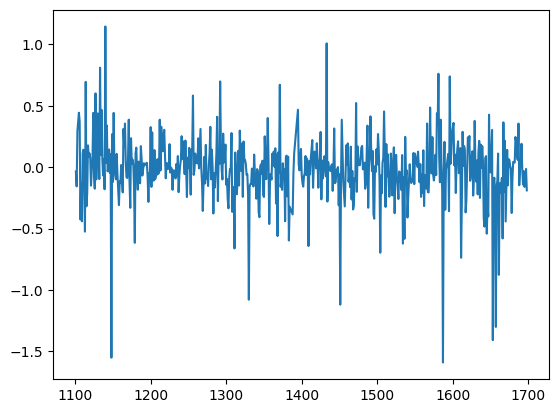

In [29]:
from matplotlib import pyplot as plt
plt.plot(symbol_0_dates['date_id'],symbol_0_dates['responder_6'])
plt.show()